# 开头

$Stacking$是一种通用的通过训练学习器来结合个体学习器的方法。此时，个体学习器被称为一级学习器，结合学习器被称为二级学习器，或者元学习器。

$stacking$严格来说并不是一种算法，而是精美而又复杂的，对模型集成的一种策略。$Stacking$集成算法可以理解为一个两层的集成，第一层含有多个基础分类器，把预测的结果(元特征)提供给第二层， 而第二层的分类器通常是逻辑回归，他把一层分类器的结果当做特征做拟合输出预测结果。

# Blending集成学习算法

不知道大家小时候有没有过这种经历：老师上课提问到你，那时候你因为开小差而无法立刻得知问题的答案。就在你彷徨的时候，由于你平时人缘比较好，因此周围的同学向你伸出援手告诉了你他们脑中的正确答案，因此你对他们的答案加以总结和分析最终的得出正确答案。相信大家都有过这样的经历，说这个故事的目的是为了引出集成学习家族中的Blending方式，这种集成方式跟我们的故事是十分相像的。如图：(图片来源：https://blog.csdn.net/maqunfi/article/details/82220115)                                                                     

![jupyter](./1.png)                                                   
下面我们来详细讨论下这个Blending集成学习方式：                             
   - (1) 将数据划分为训练集和测试集(test_set)，其中训练集需要再次划分为训练集(train_set)和验证集(val_set)；
   - (2) 创建第一层的多个模型，这些模型可以使同质的也可以是异质的；
   - (3) 使用train_set训练步骤2中的多个模型，然后用训练好的模型预测val_set和test_set得到val_predict, test_predict1；
   - (4) 创建第二层的模型,使用val_predict作为训练集训练第二层的模型；
   - (5) 使用第二层训练好的模型对第二层测试集test_predict1进行预测，该结果为整个测试集的结果。                        
   
![jupyter](./2.png)                               
(图片来源：https://blog.csdn.net/sinat_35821976/article/details/83622594)                                                                          

在这里，笔者先来梳理下这个过程：                             
在(1)步中，总的数据集被分成训练集和测试集，如80%训练集和20%测试集，然后在这80%的训练集中再拆分训练集70%和验证集30%，因此拆分后的数据集由三部分组成：训练集80%* 70%
、测试集20%、验证集80%* 30% 。训练集是为了训练模型，测试集是为了调整模型(调参)，测试集则是为了检验模型的优度。                                             
在(2)-(3)步中，我们使用训练集创建了K个模型，如SVM、random forests、XGBoost等，这个是第一层的模型。 训练好模型后将**验证集**输入模型进行预测，得到K组不同的输出，我们记作$A_1,...,A_K$，然后将测试集输入K个模型也得到K组输出，我们记作$B_1,...,B_K$，其中$A_i$的样本数与验证集一致，$B_i$的样本数与测试集一致。如果总的样本数有10000个样本，那么使用5600个样本训练了K个模型，输入验证集2400个样本得到K组2400个样本的结果$A_1,...,A_K$，输入测试集2000个得到K组2000个样本的结果$B_1,...,B_K$ 。                             
在(4)步中，我们使用K组2400个样本的验证集结果$A_1,...,A_K$作为第二层分类器的特征，验证集的2400个标签为因变量，训练第二层分类器，得到2400个样本的输出。                                  
在(5)步中，将输入测试集2000个得到K组2000个样本的结果$B_1,...,B_K$放入第二层分类器，得到2000个测试集的预测结果。                                        

![jupyter](./3.jpg)

以上是Blending集成方式的过程，接下来我们来分析这个集成方式的优劣：                                          
其中一个最重要的优点就是实现简单粗暴，没有太多的理论的分析。但是这个方法的缺点也是显然的：blending只使用了一部分数据集作为留出集进行验证，也就是只能用上数据中的一部分，实际上这对数据来说是很奢侈浪费的。                                                          
关于这个缺点，我们以后再做改进，我们先来用一些案例来使用这个集成方式。

In [1]:
# 加载相关工具包
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

In [2]:
# 创建数据
from sklearn import datasets 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
data, target = make_blobs(n_samples=10000, centers=2, random_state=1, cluster_std=1.0 )
## 创建训练集和测试集
X_train1,X_test,y_train1,y_test = train_test_split(data, target, test_size=0.2, random_state=1)
## 创建训练集和验证集
X_train,X_val,y_train,y_val = train_test_split(X_train1, y_train1, test_size=0.3, random_state=1)
print("The shape of training X:",X_train.shape)
print("The shape of training y:",y_train.shape)
print("The shape of test X:",X_test.shape)
print("The shape of test y:",y_test.shape)
print("The shape of validation X:",X_val.shape)
print("The shape of validation y:",y_val.shape)

The shape of training X: (5600, 2)
The shape of training y: (5600,)
The shape of test X: (2000, 2)
The shape of test y: (2000,)
The shape of validation X: (2400, 2)
The shape of validation y: (2400,)


In [3]:
#  设置第一层分类器
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clfs = [SVC(probability = True),RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),KNeighborsClassifier()]

# 设置第二层分类器
from sklearn.linear_model import LinearRegression
lr = LinearRegression()



In [4]:
# 输出第一层的验证集结果与测试集结果
val_features = np.zeros((X_val.shape[0],len(clfs)))  # 初始化验证集结果
test_features = np.zeros((X_test.shape[0],len(clfs)))  # 初始化测试集结果

for i,clf in enumerate(clfs):
    clf.fit(X_train,y_train)
    val_feature = clf.predict_proba(X_val)[:, 1]
    test_feature = clf.predict_proba(X_test)[:,1]
    val_features[:,i] = val_feature
    test_features[:,i] = test_feature
    

In [5]:
# 将第一层的验证集的结果输入第二层训练第二层分类器
lr.fit(val_features,y_val)
# 输出预测的结果
from sklearn.model_selection import cross_val_score
cross_val_score(lr,test_features,y_test,cv=5)

array([1., 1., 1., 1., 1.])

可以看到，在每一折的交叉验证的效果都是非常好的，这个集成学习方法在这个数据集上是十分有效的。

## 使用Blending方式对iris数据集进行预测

In [6]:
# 创建数据
from sklearn import datasets 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
## 创建训练集和测试集
X_train1,X_test,y_train1,y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=1)
## 创建训练集和验证集
X_train,X_val,y_train,y_val = train_test_split(X_train1, y_train1, test_size=0.3, random_state=1)
print("The shape of training X:",X_train.shape)
print("The shape of training y:",y_train.shape)
print("The shape of test X:",X_test.shape)
print("The shape of test y:",y_test.shape)
print("The shape of validation X:",X_val.shape)
print("The shape of validation y:",y_val.shape)

The shape of training X: (84, 4)
The shape of training y: (84,)
The shape of test X: (30, 4)
The shape of test y: (30,)
The shape of validation X: (36, 4)
The shape of validation y: (36,)


In [36]:
"""#  设置第一层分类器
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clfs = [SVC(probability = True),RandomForestClassifier(),KNeighborsClassifier()]"""

# 设置第一层分类器
# 感谢大佬 @侍伟 提供的挑参方法
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
clfs = [SVC(probability = True,C= 1, kernel= 'linear'),
        RandomForestClassifier(n_estimators=30, max_depth=9,min_samples_split=50,n_jobs=-1,criterion='gini'),
        KNeighborsClassifier(n_neighbors=7)]

# 设置第二层分类器
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial')

In [37]:
val_features = np.zeros((X_val.shape[0],len(clfs)*2))  # 初始化验证集结果
test_features = np.zeros((X_test.shape[0],len(clfs)*2))  # 初始化测试集结果

for i,clf in enumerate(clfs):
    clf.fit(X_train,y_train)
    val_feature = clf.predict_proba(X_val)[:,0:2]
    test_feature = clf.predict_proba(X_test)[:,0:2]
    val_features[:,i*2] = val_feature[:,0]
    val_features[:,i*2+1] = val_feature[:,1]
    test_features[:,i*2] = test_feature[:,0]
    test_features[:,i*2+1] = test_feature[:,1]
    

In [38]:
# 将第一层的验证集的结果输入第二层训练第二层分类器
lr.fit(val_features,y_val)
# 输出预测的结果
from sklearn.model_selection import cross_val_score
cross_val_score(lr,test_features,y_test,cv=5)

array([1., 1., 1., 1., 1.])

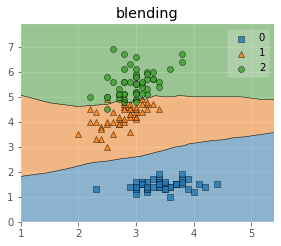

In [41]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:, 1:3], iris.target

# 我们画出决策边界
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf], 
                         ['blending'],
                          itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()